In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
from keras.utils import np_utils
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
#from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import save_model


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
NB_CLASSES = 4 # number of outputs = number of classes
VERBOSE = 1
BATCH_SIZE = 10
NB_EPOCH = 100
target_names = ['Non-MO', 'MO']
file_short = "D:/BMO/Main/savedModels/0input_model_short.h5"
file_mid1 = "D:/BMO/Main/savedModels/0input_model_mid1.h5"
file_mid2 = "D:/BMO/Main/savedModels/0input_model_mid2.h5"
file_long = "D:/BMO/Main/savedModels/0input_model_long.h5"
file_best = "D:/BMO/Main/savedModels/0input_model_best.h5"

In [3]:
symbol_length =   [1, 128, 1024, 1800, 2048]

In [4]:
%%time

print(".........Loading MO (2-state) dataset..........")


# sep separates each column and header = none means it is going to read from row 1
re2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/BPSK-2/real_snr05.csv',sep=',', header=None) 
im2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/BPSK-2/im_snr05.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/QPSK-2/real_snr05.csv',sep=',', header=None) 
im4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/QPSK-2/im_snr05.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/16-QAM-2/real_snr05.csv',sep=',', header=None) 
im16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/16-QAM-2/im_snr05.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/64-QAM-2/real_snr05.csv',sep=',', header=None) 
im64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/64-QAM-2/im_snr05.csv',sep=',', header=None)


#merge two dataframes into one
df2psk_2st = re2psk_2st + im2psk_2st * 1j
df2psk_2st['Mod'] = 0 # 0 = BPSK 2-state
#merge two dataframes into one
df4psk_2st = re4psk_2st + im4psk_2st * 1j
df4psk_2st['Mod'] = 1 # 1 = QPSK 2-state
#merge two dataframes into one
df16qam_2st = re16qam_2st + im16qam_2st * 1j
df16qam_2st['Mod'] = 2 # 2 = 16-QAM 2-state
#merge two dataframes into one
df64qam_2st = re64qam_2st + im64qam_2st * 1j
df64qam_2st['Mod'] = 3 # 3 = 64-QAM 2-state

# combine all
df_2st = df2psk_2st.append(df4psk_2st)
df_2st = df_2st.append(df16qam_2st)
df_2st = df_2st.append(df64qam_2st)

#df_mo = df_2st
#df_mo = df_mo.sample(frac = 1)
print('df_mo Shape = ', df_2st.shape)

.........Loading MO (2-state) dataset..........
df_mo Shape =  (28000, 2049)
CPU times: total: 1min
Wall time: 1min 43s


In [5]:
print("..........Combining all data..........")

# combine all
#df = df_mo.append(df_nonmo)
df_all = df_2st.sample(frac = 1)
print('df_all Shape = ', df_all.shape)
print("..........Shuffling done..........")

# reducing samples to tune only
#df_all = df_all.iloc[:16384]
print('df_all Size = ', df_all.size)
print('Dimension = ', df_all.ndim)
print('Combined Shape = ', df_all.shape)

..........Combining all data..........
df_all Shape =  (28000, 2049)
..........Shuffling done..........
df_all Size =  57372000
Dimension =  2
Combined Shape =  (28000, 2049)


In [6]:
%%time

f1_bp = []
f1_qp = []
f1_16 = []
f1_64 = []
re_bp = []
re_qp = []
re_16 = []
re_64 = []
pr_bp = []
pr_qp = []
pr_16 = []
pr_64 = []
ac_bp = []
ac_qp = []
ac_16 = []
ac_64 = []

f1mc_bp = []
f1mc_qp = []
f1mc_16 = []
f1mc_64 = []
remc_bp = []
remc_qp = []
remc_16 = []
remc_64 = []
prmc_bp = []
prmc_qp = []
prmc_16 = []
prmc_64 = []
acmc_bp = []
acmc_qp = []
acmc_16 = []
acmc_64 = []

accuracy = []
f1score = []
loss = []
precision = []
false_pos = []
true_pos = []
recall = []

for LENGTH in symbol_length:
    
    # Separating X and y
    y = df_all['Mod'] # 1D targer vector
    X = df_all.drop(columns='Mod')

    INPUT_SHAPE = (LENGTH,1)

    X.drop(X.iloc[:, LENGTH:2048], inplace = True, axis = 1)

    X = np.expand_dims(X, -1)

    # Split into training/testing sets with 20% split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) 

    print("..........Training set..........")
    print(X_train.shape)
    print(y_train.shape)
    print("..........Validation set..........")
    print(X_val.shape)
    print(y_val.shape)
    print("..........Testing set..........")
    print(X_test.shape)
    print(y_test.shape)

    # Convert class vectors to categorical classes matrices
    y_train = np_utils.to_categorical(y_train, NB_CLASSES)
    y_test = np_utils.to_categorical(y_test, NB_CLASSES)
    y_val = np_utils.to_categorical(y_val, NB_CLASSES)

    from keras.constraints import maxnorm

    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        filter_num = ['None',32,64,128,256]
        kernel_size = ['None',8,8,8,8]
        conv_stride_size = ['None',1,1,1,1]
        pool_stride_size = ['None',4,4,4,4]
        pool_size = ['None',8,8,8,8]
        batch_size = 10
        dropout_rate =0.0
        # Feature extraction
        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=INPUT_SHAPE,
                             strides=conv_stride_size[1], padding='same',
                             name='convolution1'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation1'))
        model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                                   padding='same', name='pool1'))
        model.add(Dropout(dropout_rate, name='dropout1'))
        
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation2'))
        model.add(MaxPooling1D(pool_size=pool_size[2], strides=pool_stride_size[2],
                                   padding='same', name='pool2'))
        model.add(Dropout(dropout_rate, name='dropout2'))

        # Output layer
        model.add(Flatten(name='flatten1'))
        model.add(Dense(NB_CLASSES, kernel_initializer=glorot_uniform(seed=0), name='dense1'))
        model.add(Activation('softmax', name="softmax"))

        # Compile model
        model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.6), metrics=["accuracy"])

        return model

    model = create_model()
    # simple early stopping
    es_lr = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc_lr = ModelCheckpoint(file_best, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # fit model
    model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
                                validation_data=(X_val, y_val), callbacks=[es_lr, mc_lr])
  #  model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
   #                             validation_data=(X_val, y_val))
    
    
    if(LENGTH==128):
        save_model(model, file_short)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_short = confusion_matrix(y_test1, y_pred1)
        cmratio_short = cm_short.astype('float') / cm_short.sum(axis=1)[:, np.newaxis]
        cmratio_short= np.around(cmratio_short.astype('float') / cmratio_short.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==512):
        save_model(model, file_mid1)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_mid1 = confusion_matrix(y_test1, y_pred1)
        cmratio_mid1 = cm_mid1.astype('float') / cm_mid1.sum(axis=1)[:, np.newaxis]
        cmratio_mid1= np.around(cmratio_mid1.astype('float') / cmratio_mid1.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==1536):
        save_model(model, file_mid2)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_mid2 = confusion_matrix(y_test1, y_pred1)
        cmratio_mid2 = cm_mid2.astype('float') / cm_mid2.sum(axis=1)[:, np.newaxis]
        cmratio_mid2= np.around(cmratio_mid2.astype('float') / cmratio_mid2.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==2048):
        save_model(model, file_long)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_long = confusion_matrix(y_test1, y_pred1)
        cmratio_long = cm_long.astype('float') / cm_long.sum(axis=1)[:, np.newaxis]
        cmratio_long= np.around(cmratio_long.astype('float') / cmratio_long.sum(axis=1)[:, np.newaxis], decimals=1)
        
    # Start evaluating model with testing data
    score_test = model.evaluate(X_test, y_test, verbose=VERBOSE)
    y_pred = model.predict(X_test)
    
    y_pred1=np.argmax(y_pred, axis=1)
    y_test1=np.argmax(y_test, axis=1)
    #cm = confusion_matrix(y_test1, y_pred1
    
    acc = score_test[1]
    accuracy.append(acc)
    
    ls = score_test[0]
    loss.append(ls)
    
    f1s = f1_score(y_test1, y_pred1, average=None)
    f1score.append((f1s[0]+f1s[1])/2)
    print(f1s)
    for index, val in np.ndenumerate(f1s):
            if (index[0]==0): 
                f1bp = val
            if (index[0]==1): 
                f1qp = val
            if (index[0]==2):
                f116 = val
            if (index[0]==3): 
                f164 = val
           
    f1_bp.append(f1bp)
    f1_qp.append(f1qp)
    f1_16.append(f116)
    f1_64.append(f164)
    
    
    cm = confusion_matrix(y_test1, y_pred1)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print('Confusion Matrix when Symbol Length ', LENGTH)
    #f = sns.heatmap(cm, cmap='Greens', annot=True, square=True, yticklabels = True)
    #cmratio = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #plt.rcParams["figure.figsize"] = (7.5,7.5)
    #plt.rcParams.update({'font.size': 14})
    #f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)
    
    accuracys = cm.diagonal()
    #acc = accuracy.reshape(-1,1)
    print(accuracys)
    for index, val in np.ndenumerate(accuracys):
            if (index[0]==0): 
                abp = val
            if (index[0]==1): 
                aqp = val
            if (index[0]==2):
                a16 = val
            if (index[0]==3): 
                a64 = val
           
    ac_bp.append(abp)
    ac_qp.append(aqp)
    ac_16.append(a16)
    ac_64.append(a64)

..........Training set..........
(20160, 1, 1)
(20160,)
..........Validation set..........
(2240, 1, 1)
(2240,)
..........Testing set..........
(5600, 1, 1)
(5600,)
Epoch 1/100
620/630 [============================>.] - ETA: 0s - loss: 1.4050 - accuracy: 0.2509
Epoch 1: val_accuracy improved from -inf to 0.26295, saving model to D:/BMO/Main/savedModels\0input_model_best.h5
630/630 [==============================] - 5s 5ms/step - loss: 1.4047 - accuracy: 0.2511 - val_loss: 1.3921 - val_accuracy: 0.2629
Epoch 2/100
628/630 [============================>.] - ETA: 0s - loss: 1.3907 - accuracy: 0.2487
Epoch 2: val_accuracy did not improve from 0.26295
630/630 [==============================] - 3s 4ms/step - loss: 1.3907 - accuracy: 0.2491 - val_loss: 1.3945 - val_accuracy: 0.2388
Epoch 3/100
624/630 [============================>.] - ETA: 0s - loss: 1.3907 - accuracy: 0.2494
Epoch 3: val_accuracy did not improve from 0.26295
630/630 [==============================] - 3s 4ms/step - loss: 1.3

624/630 [============================>.] - ETA: 0s - loss: 1.3894 - accuracy: 0.2516
Epoch 29: val_accuracy did not improve from 0.26384
630/630 [==============================] - 2s 4ms/step - loss: 1.3894 - accuracy: 0.2520 - val_loss: 1.3929 - val_accuracy: 0.2500
Epoch 30/100
624/630 [============================>.] - ETA: 0s - loss: 1.3900 - accuracy: 0.2470
Epoch 30: val_accuracy did not improve from 0.26384
630/630 [==============================] - 2s 4ms/step - loss: 1.3900 - accuracy: 0.2470 - val_loss: 1.3864 - val_accuracy: 0.2438
Epoch 31/100
629/630 [============================>.] - ETA: 0s - loss: 1.3892 - accuracy: 0.2534
Epoch 31: val_accuracy did not improve from 0.26384
630/630 [==============================] - 2s 4ms/step - loss: 1.3892 - accuracy: 0.2534 - val_loss: 1.3894 - val_accuracy: 0.2455
Epoch 32/100
616/630 [============================>.] - ETA: 0s - loss: 1.3897 - accuracy: 0.2476
Epoch 32: val_accuracy did not improve from 0.26384
630/630 [===========

Epoch 6/100
627/630 [============================>.] - ETA: 0s - loss: 1.0323 - accuracy: 0.5313
Epoch 6: val_accuracy improved from 0.52143 to 0.52455, saving model to D:/BMO/Main/savedModels\0input_model_best.h5
630/630 [==============================] - 7s 11ms/step - loss: 1.0314 - accuracy: 0.5317 - val_loss: 1.0277 - val_accuracy: 0.5246
Epoch 7/100
626/630 [============================>.] - ETA: 0s - loss: 1.0284 - accuracy: 0.5347
Epoch 7: val_accuracy improved from 0.52455 to 0.52946, saving model to D:/BMO/Main/savedModels\0input_model_best.h5
630/630 [==============================] - 7s 11ms/step - loss: 1.0285 - accuracy: 0.5349 - val_loss: 1.0230 - val_accuracy: 0.5295
Epoch 8/100
626/630 [============================>.] - ETA: 0s - loss: 1.0181 - accuracy: 0.5362
Epoch 8: val_accuracy did not improve from 0.52946
630/630 [==============================] - 7s 12ms/step - loss: 1.0183 - accuracy: 0.5361 - val_loss: 1.0468 - val_accuracy: 0.5214
Epoch 9/100
625/630 [=======

Epoch 33/100
630/630 [==============================] - ETA: 0s - loss: 0.9686 - accuracy: 0.5634
Epoch 33: val_accuracy did not improve from 0.55045
630/630 [==============================] - 7s 11ms/step - loss: 0.9686 - accuracy: 0.5634 - val_loss: 0.9902 - val_accuracy: 0.5496
Epoch 34/100
628/630 [============================>.] - ETA: 0s - loss: 0.9718 - accuracy: 0.5628
Epoch 34: val_accuracy did not improve from 0.55045
630/630 [==============================] - 7s 11ms/step - loss: 0.9719 - accuracy: 0.5627 - val_loss: 1.0077 - val_accuracy: 0.5424
Epoch 35/100
628/630 [============================>.] - ETA: 0s - loss: 0.9696 - accuracy: 0.5654
Epoch 35: val_accuracy did not improve from 0.55045
630/630 [==============================] - 7s 11ms/step - loss: 0.9696 - accuracy: 0.5656 - val_loss: 1.0000 - val_accuracy: 0.5424
Epoch 36/100
627/630 [============================>.] - ETA: 0s - loss: 0.9680 - accuracy: 0.5668
Epoch 36: val_accuracy did not improve from 0.55045
630/

630/630 [==============================] - 30s 47ms/step - loss: 0.3762 - accuracy: 0.8466 - val_loss: 0.4372 - val_accuracy: 0.8210
Epoch 12/100
630/630 [==============================] - ETA: 0s - loss: 0.3942 - accuracy: 0.8376
Epoch 12: val_accuracy did not improve from 0.82098
630/630 [==============================] - 33s 52ms/step - loss: 0.3942 - accuracy: 0.8376 - val_loss: 0.4462 - val_accuracy: 0.8134
Epoch 13/100
629/630 [============================>.] - ETA: 0s - loss: 0.3781 - accuracy: 0.8465
Epoch 13: val_accuracy did not improve from 0.82098
630/630 [==============================] - 31s 50ms/step - loss: 0.3780 - accuracy: 0.8466 - val_loss: 0.4581 - val_accuracy: 0.8205
Epoch 14/100
629/630 [============================>.] - ETA: 0s - loss: 0.3548 - accuracy: 0.8556
Epoch 14: val_accuracy improved from 0.82098 to 0.83438, saving model to D:/BMO/Main/savedModels\0input_model_best.h5
630/630 [==============================] - 29s 47ms/step - loss: 0.3549 - accuracy: 0

630/630 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8388
Epoch 4: val_accuracy improved from 0.77545 to 0.82946, saving model to D:/BMO/Main/savedModels\0input_model_best.h5
630/630 [==============================] - 47s 74ms/step - loss: 0.3998 - accuracy: 0.8388 - val_loss: 0.4106 - val_accuracy: 0.8295
Epoch 5/100
630/630 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.8516
Epoch 5: val_accuracy did not improve from 0.82946
630/630 [==============================] - 46s 73ms/step - loss: 0.3653 - accuracy: 0.8516 - val_loss: 0.4763 - val_accuracy: 0.8116
Epoch 6/100
630/630 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8616
Epoch 6: val_accuracy did not improve from 0.82946
630/630 [==============================] - 45s 72ms/step - loss: 0.3515 - accuracy: 0.8616 - val_loss: 0.4740 - val_accuracy: 0.8022
Epoch 7/100
630/630 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.8701
Epoch 

Epoch 31: early stopping
175/175 [==============================] - 3s 18ms/step
[0.70935961 0.75489534 0.99263933 0.8950059 ]
[0.73900293 0.76785714 0.99090273 0.84233901]
..........Training set..........
(20160, 2048, 1)
(20160,)
..........Validation set..........
(2240, 2048, 1)
(2240,)
..........Testing set..........
(5600, 2048, 1)
(5600,)
Epoch 1/100
630/630 [==============================] - ETA: 0s - loss: 1.2050 - accuracy: 0.6632
Epoch 1: val_accuracy improved from -inf to 0.77857, saving model to D:/BMO/Main/savedModels\0input_model_best.h5
630/630 [==============================] - 52s 79ms/step - loss: 1.2050 - accuracy: 0.6632 - val_loss: 0.4997 - val_accuracy: 0.7786
Epoch 2/100
630/630 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8177
Epoch 2: val_accuracy improved from 0.77857 to 0.85179, saving model to D:/BMO/Main/savedModels\0input_model_best.h5
630/630 [==============================] - 51s 81ms/step - loss: 0.4447 - accuracy: 0.8177 - va

Saved model to disk
Confusion Matrix when Symbol Length  2048
175/175 [==============================] - 2s 12ms/step
[0.74668528 0.74847126 0.99686083 0.88122097]
[0.78445748 0.63049451 1.         0.98297557]
CPU times: total: 3h 29min 44s
Wall time: 1h 5min 42s


In [7]:
print("Symbol series length = ", LENGTH)

y_pred1=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test1, y_pred1)
print(cm)
#f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)

Symbol series length =  2048
[[1070   78    3  213]
 [ 410  918    6  122]
 [   0    0 1429    0]
 [  22    1    0 1328]]


In [8]:
print(accuracy)

[0.24017857015132904, 0.5483928322792053, 0.7162500023841858, 0.8357142806053162, 0.8473214507102966]


[0.24017857015132904, 0.5483928322792053, 0.7162500023841858, 0.8357142806053162, 0.8473214507102966]
[1.3931570053100586, 0.9872667789459229, 1.0511842966079712, 0.5184050798416138, 0.5668250322341919]
[0.16810530858869227, 0.43470774142869434, 0.5564906500850606, 0.7321274734485752, 0.7475782676637605]


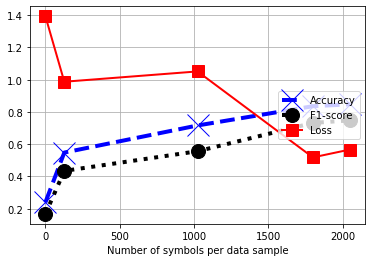

In [9]:
print(accuracy)
print(loss)
print(f1score)
# Plot Graph
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 30})

fig, ax1 = plt.subplots()

ax1.plot(symbol_length, accuracy, color='b', linestyle='dashed', linewidth =4,
         marker='x', markerfacecolor='white', markersize=22, label='Accuracy')
ax1.plot(symbol_length, f1score, color='k', linestyle=':', linewidth =4,
         marker='o', markerfacecolor='k', markersize=14, label='F1-score')
ax1.plot(symbol_length, loss, color='r', linestyle='-', linewidth = 2,
         marker='s', markerfacecolor='r', markersize=12, label='Loss')

ax1.set_xlabel('Number of symbols per data sample')
#ax1.set_ylabel('Score')
plt.grid()
#plt.ylim(0.14, 1.0)
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='center right')

plt.show()